In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################


這次的範例主要參考[ShangtongZhang](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter07/random_walk.py)

Chapter 8主要結合planning與learning，讓過往的經驗可以再次得到一次利用

Example 8.2: Blocking Maze

Figure 8.4說明了一個相對較小的模型誤差(modeling error)並且從中恢復。最一開始障礙的右邊會有一個從開始到目標的短徑(short path)，如圖左上所示。然後在1000個time steps之後，這條短徑被河蟹了，你變成要從障礙物的左邊缺點去走這條更長的路徑，如圖右上所示。

![](https://i.imgur.com/pj7Yt2F.png)
Figure 8.4：Dyna agents在blocking task的平均效能。左圖是前1000個steps，右圖是剩下的steps。Dyna-Q+是鼓勵探索版本的Dyna-Q，有著探索獎勵。

Figure 8.4說明著Dyna-Q agent與Dyna-Q+ agent(後面就會說到)的average cumulative reward。第一個部份說明的是，兩個Dyna agents在1000個steps內找到最短路徑。當環境(environment)改變的時候，你會發現有一小段的average cumulative reward變的平坦，因為它們卡到了，在障礙物後面一直走來走去的。不過一段時間之後也可以看的到，它們又找到新的開口以及新的optimal behvaior。當環境變的比之前更好的時候，而先前正確的策略(policy)卻沒有顯示出有任何改善，就會出現更大的困難。這種情況下，modeling error會有很長的一段時間無法被偵測到(如果有的話)。

首先載入需求套件

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import heapq
from copy import deepcopy

首先設置Environment，要注意一下這邊的一些設置是跟Example 8.1不一樣的

In [3]:
class Maze:
    def __init__(self):
        """初始化環境
        
        根據範例說明：
        1. 這是一個寬9高6的gridworld
        2. 每個episode的start state都是[5, 3]
        3. goal state為[0, 8]
        4. 我們能做的action就是上下左右
        5. 路面上是有障礙
        6. 在1000個step之後障礙就會變動
        """
        self.WORLD_WIDTH = 9
        self.WORLD_HEIGHT = 6
        
        self.START_STATE = [5, 3]
        self.GOAL_STATE = [0, 8]
        
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.action_space = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]
        
        # 障礙設置
        # 這次的範例中，障礙是會變動的
        self.obstacles = None
        self.old_obstacles = [[3, i] for i in range(0, 8)]
        self.new_obstacles = [[3, i] for i in range(1, 9)]
        
        self.value_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.action_space))
        
        # 根據範例的圖片來設置
        self.max_steps = 3000
        
        # 1000個step之後環境變換
        self.time_to_switch = 1000
        
    def step(self, state, action):
        """run step according action
        
        state: 當前的狀態
        action: 要執行的action
        
        幾點要注意：
            1. 不能超出邊界，這可以用max、min來處理
            2. 撞到障礙就是停在原地
            3. 每次的reward都是0，除非你到達goal state
            
        return next_state, reward
        """
        x, y = state
        
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif  action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif  action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif  action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        
        if [x, y] in self.obstacles:
            x, y = state
        
        if [x, y] == self.GOAL_STATE:
            reward = 1.0
        else:
            reward = 0.0
        
        return [x, y], reward
        

In [4]:
maze = Maze()
maze.obstacles = maze.old_obstacles
assert maze.START_STATE == [5, 3]
assert maze.GOAL_STATE == [0, 8]
assert (maze.step([5, 3], 0)) == ([4, 3], 0)

我們會需要一個model來記錄曾經有過的經驗，這個model是for Dyna-Q的

In [5]:
class TrivialModel:
    def __init__(self, rand=np.random):
        # 用dict來做模型，反正我們只會記錄該state-action pair最後一次的經驗
        self.model = dict()
        self.rand = rand
#         self.rand.seed(10)
    
    def feed(self, state, action, next_state, reward):
        """記錄經驗"""
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        
        # 判斷該組state是否存在目前的model
        # 如不存在就賦予一個預設值
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]
        
    def sample(self):
        """隨機取一筆經驗出來"""
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

我們需要另一個model來滿足Dyna-Q+的需求

In [6]:
class TimeModel:
    def __init__(self, maze, time_weight=1e-4, rand=np.random):
        """
        maze: Maze object
        time_weight: 時間所賦予的權重
        rand: numpy random function
        """
        self.rand = rand
        self.model = dict()
        # 追蹤記錄total time
        self.time = 0
        self.time_weight = time_weight
        self.maze = maze
        
    def feed(self, state, action, next_state, reward):
        """記錄經驗
        
        我們需要先判斷一下相關經驗是否已經存在，不存在就先設置初始格式再寫入
        剩下這個state沒有被執行過的action我們就另外做個記錄
        只是記錄的next state會是current state        
        """
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        
        self.time +=1
        
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
            
            for _action in self.maze.action_space:
                if _action != action:
                    # 這邊要注意，next_state記錄的是current state
                    # 意思就是，當我們後面去遇到這個state-action pair的時候
                    # 我們就會從current state再往下走，而不會真正的轉至下一個state
                    # 當這個pair第一次被sample到的時候，雖然reward是0，但是還是會有一個bouns reward
                    # 這也合理，沒走過的你也不知道走了以後會怎麼樣，但是它逐漸的累積之後
                    # 總是有機會被選到，那就能真正的知道它的下一個狀態是怎麼了
                    self.model[tuple(state)][_action] =[list(state), 0, 1]
        
        self.model[tuple(state)][action] = [list(next_state), reward, self.time]
    
    def sample(self):
        """隨機取一筆經驗出來"""
        state_index = self.rand.choice(range(len(self.model.keys())))
        state  = list(self.model)[state_index]
        
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        
        # 這邊我們假設我們真的去sample到那個沒被選過的pair
        # next_state還會是state
        # 然後這個pair已經好久沒有出現，所以有bouns reward之後，其reward還是會增長
        next_state, reward, time = self.model[state][action]
        reward += self.time_weight * np.sqrt(self.time - time)
        
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        
        return list(state), action, list(next_state), reward

然後我們來設置一下Dyna-Q所需要的參數：
* gamma: discount factor
* epsilon: 探索的機率
* planning_steps: planning steps
* average_runs: 幾次的run計算平均

In [7]:
dyna_q_params = {
    'gamma': 0.95,
    'epsilon': 0.1,
    'planning_steps': 10,
    'average_runs': 20,     
    'alpha': 1.0,
    'time_weight': 1e-4,
    'methods': ['Dyna-Q', 'Dyna-Q+']
}

In [8]:
dyna_q_params

{'gamma': 0.95,
 'epsilon': 0.1,
 'planning_steps': 10,
 'average_runs': 20,
 'alpha': 1.0,
 'time_weight': 0.0001,
 'methods': ['Dyna-Q', 'Dyna-Q+']}

設置一個已經很熟悉的，用來選擇action的function

In [9]:
def action_selection(state, value_function, maze, dyna_params):
    """選擇action的function
    
    後來自己被很多q_value參數搞混，所以就試著分開來命名
    
    state: current state
    value_function: action value function, that is q_value
    maze: object for Maze
    dyna_params: algorithm's parameters
    """
    if np.random.binomial(1, dyna_q_params['epsilon']) == 1:
        return np.random.choice(maze.action_space)
    else:
        # 取得該state的所有可能的action
        values = value_function[state[0], state[1], :]
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])
    

接著來設置Dyna-Q algorithm，下面給出完整演算法的pseudocode

![](https://i.imgur.com/jo168Rh.png)

In [10]:
def dyna_q_algorithm(q_value, model, maze, params):
    """dyna_q algorithm
    
    q_value: action-value function
    model: for planning
    maze: environment
    params: for dyna_q's parameters
    
    見上演算法說明
    """
    # (a) current state
    state = maze.START_STATE
    steps = 0
    
    # 一直到agent走到目標之前就是一路迴圈執行
    while state != maze.GOAL_STATE:        
        # 記錄當下的steps
        steps += 1
        
        # (b) 取得action
        action = action_selection(state, q_value, maze, params)
        
        # (c) 執行action，得到next state與reward
        next_state, reward = maze.step(state, action)
        
        # (d) 做一次Q-learning的更新
        q_value[state[0], state[1], action] += \
            params['alpha'] * (reward + params['gamma'] * np.max(q_value[next_state[0], next_state[1], :]) \
                - q_value[state[0], state[1], action])
        
        # (e) 資料寫入模型
        model.feed(state, action, next_state, reward)
        
        # (f) 迴圈執行planning_steps次
        for t in range(0, params['planning_steps']):            
            # 隨機的從模型中取一筆資料
            # 從經驗中學習，其實就是用sample到的資料再做一次更新
            _state, _action, _next_state, _reward = model.sample()
            q_value[_state[0], _state[1], _action] += \
            params['alpha'] * (_reward + params['gamma'] * np.max(q_value[_next_state[0], _next_state[1], :]) \
                - q_value[_state[0], _state[1], _action])
            
        state = next_state
        
        if steps > maze.max_steps:
            break
    
    return steps

演算法的部份也已經好了，現在我們可以來處理實際要執行的過程了

首先初始化需求的物件

In [11]:
blocking_maze = Maze()

然後我們也已經有env的參數

In [12]:
dyna_q_params

{'gamma': 0.95,
 'epsilon': 0.1,
 'planning_steps': 10,
 'average_runs': 20,
 'alpha': 1.0,
 'time_weight': 0.0001,
 'methods': ['Dyna-Q', 'Dyna-Q+']}

接下來設置一些過程中需要的參數

In [13]:
max_steps = blocking_maze.max_steps
rewards = np.zeros((dyna_q_params['average_runs'], 2, max_steps))
# 20run、2個model、3000個steps
rewards.shape

(20, 2, 3000)

In [14]:
%%time
# 執行20次
for run in tqdm(range(dyna_q_params['average_runs'])):
    # 初始化兩個model
    models = [TrivialModel(), TimeModel(blocking_maze,  dyna_q_params['time_weight'])]
    
    # 初始化兩種演算法的action value
    q_values = [np.zeros(blocking_maze.value_size), np.zeros(blocking_maze.value_size)]
    
    for i in range(len(dyna_q_params['methods'])):
        # 一開始是左邊開個洞的迷宮
        blocking_maze.obstacles = blocking_maze.old_obstacles
        
        # 初始化step
        steps = 0
        last_steps = steps
        # 3000個step為極限做迴圈
        while steps < max_steps:
            steps += dyna_q_algorithm(q_values[i], models[i], blocking_maze, dyna_q_params)
            # 更新reward
            # 這個執行區間內的reward都會變成起始那一個reward
            rewards[run, i, last_steps: steps] = rewards[run, i, last_steps]
            # 累加reward
            rewards[run, i, min(steps, max_steps - 1)] = rewards[run, i, last_steps] + 1
            
            last_steps = steps
            
            # 1000個step之後環境變換
            if steps > blocking_maze.time_to_switch:
                blocking_maze.obstacles = blocking_maze.new_obstacles

100%|██████████| 20/20 [01:25<00:00,  4.27s/it]

CPU times: user 1min 25s, sys: 499 ms, total: 1min 25s
Wall time: 1min 25s


計算平均

In [15]:
# 延著0軸計算平均，所以0軸消失
rewards = rewards.mean(axis=0)
rewards.shape

(2, 3000)

繪製圖面

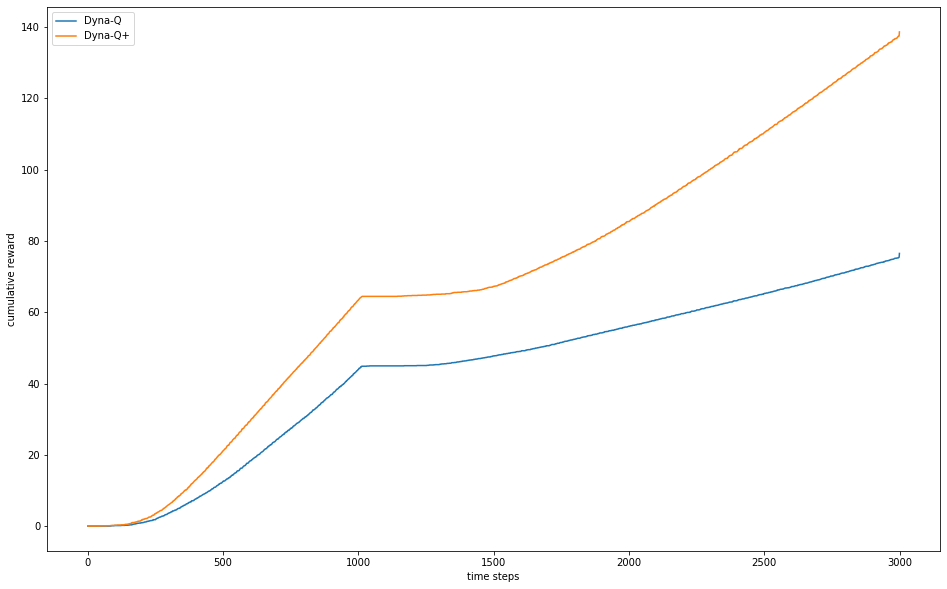

In [16]:
plt.figure(figsize=(16, 10))

for i in range(len(dyna_q_params['methods'])):
    plt.plot(rewards[i, :], label=dyna_q_params['methods'][i])

plt.xlabel('time steps')
plt.ylabel('cumulative reward')
plt.legend()
plt.show()